In [ ]:
#Importing all the necessary libraries
import numpy as np
import pandas as pd
from torch.optim import Adam
from torch.autograd import Variable
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader 
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import pathlib
from torchvision import datasets, transforms, models
from torchvision.models.alexnet import AlexNet
import seaborn as sb
import glob
from skimage import io
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from __future__ import print_function, division
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import os
import copy
from PIL import Image
from ctypes import resize
cudnn.benchmark = True
plt.ion() 
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

     |████████████████████████████████| 4.5 MB 6.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.7-py3-none-any.whl size=25953 sha256=c8b2ef574286ad3660a701038eb1b22f1746e46d9e5d82f32b77d34ebca8bb21
  Stored in directory: /root/.cache/pip/wheels/30/ab/9c/53c523785edffdc6c61755cf82e0dac3342d0d36190c187894
Successfully built grad-cam


In [ ]:
#Mounting the google drive to colab for the dataset
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


**PREPROCESSING THE IMAGES: EXTRACTING THE R,G,B CHANNELS**

In [ ]:
# Preprocessing the glaucoma 913 images 
# Spliting the images into its red, green and blue channels
# path = "/content/drive/MyDrive/LMP1210 PROJECT/Data/Glaucoma/*.*"
# i  = 0
# j = 1
# k = 2
# m = 1
# for img in glob.glob(path):
#   image = io.imread(img)
#   image_red = image[:,:,0] 
#   image_green = image[:,:,1]
#   image_blue = image[:,:,2]
#   io.imsave(f"/content/drive/MyDrive/LMP1210 PROJECT/Glaucomatous/image{i}.png", image_red)
#   io.imsave(f"/content/drive/MyDrive/LMP1210 PROJECT/Glaucomatous/image{j}.png", image_green)
#   io.imsave(f"/content/drive/MyDrive/LMP1210 PROJECT/Glaucomatous/image{k}.png", image_blue)
#   i += 1e-10
#   j += 1e-10
#   k += 1e-10
#   print(f"{m} Images is done")
#   m += 1 
  

In [ ]:
# # Preprocessing the Healthy 795 images
# # Spliting the images into its red, green and blue channels
# path = "/content/drive/MyDrive/LMP1210 PROJECT/Data/Healthy/*.*"
# i  = 0
# j = 1
# k = 2
# m = 1
# for img in glob.glob(path):
#   image = io.imread(img)
#   image_red = image[:,:,0]
#   image_green = image[:,:,1]
#   image_blue = image[:,:,2]
#   io.imsave(f"/content/drive/MyDrive/LMP1210 PROJECT/Healthy/image{i}.png", image_red)
#   io.imsave(f"/content/drive/MyDrive/LMP1210 PROJECT/Healthy/image{j}.png", image_green)
#   io.imsave(f"/content/drive/MyDrive/LMP1210 PROJECT/Healthy/image{k}.png", image_blue)
#   i += 1e-10
#   j += 1e-10
#   k += 1e-10
#   print(f"{m} Images is done")
#   m += 1 


**IMPORTING SPLITFOLDERS:**

In [ ]:
#Downloading the split-folders function to split the dataset into train, val and test sets
# !pip install split-folders
# import splitfolders

In [ ]:
image_path = "/content/drive/MyDrive/LMP1210 PROJECT/Preprocessed Data"
image_path_col = "/content/drive/MyDrive/LMP1210 PROJECT/Data"

In [ ]:
#Spliting the dataset into 60% training and 20% for validation and testing and storing it to google drive using seed for reproduceability
# splitfolders.ratio(image_path, output="/content/drive/MyDrive/LMP1210 PROJECT", seed=1337, ratio=(.7, 0.1,0.2)) 
# splitfolders.ratio(image_path_col, output="/content/drive/MyDrive/LMP1210 PROJECT/Data", seed=1337, ratio=(.7, 0.1,0.2)) 

Copying files: 1708 files [00:45, 37.78 files/s]


**LOADING THE DATASET:**

In [ ]:

# Data normalization for training, validation & testing
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
  'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/LMP1210 PROJECT'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

# Data normalization for testing the colour set only 
data_transforms = {
  'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir_col = '/content/drive/MyDrive/LMP1210 PROJECT/Data'
image_datasets_col = {x: datasets.ImageFolder(os.path.join(data_dir_col, x),
                                          data_transforms[x])
                  for x in ['test']}
dataloaders_col = {x: torch.utils.data.DataLoader(image_datasets_col[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['test']}


In [ ]:
#For resizing the images to (224x224) and converting to tensor and normalizing it
transformer = transforms.Compose([transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5,0.5,0.5],
                                                       [0.5,0.5,0.5])])

In [ ]:
#Loading the training, validation and testing data and resizing and transforming it (colab path)
train_loader =torchvision.datasets.ImageFolder('/content/drive/MyDrive/LMP1210 PROJECT/train',transform=transformer)
test_loader_col = torchvision.datasets.ImageFolder('/content/drive/MyDrive/LMP1210 PROJECT/Data/test',transform=transformer) # loading the colour images for testing 
test_loader = torchvision.datasets.ImageFolder('/content/drive/MyDrive/LMP1210 PROJECT/test',transform=transformer)
val_loader = torchvision.datasets.ImageFolder('/content/drive/MyDrive/LMP1210 PROJECT/val',transform=transformer)

In [ ]:
#This initialises DataLoader with the Dataset to help iterate through the Dataset to display the images below. 
# Shuffle will reshuffle the data at each epoch, this prevents the model from learning the order of training data.
train_loader1 = torch.utils.data.DataLoader(train_loader,batch_size=32,shuffle=True)
val_loader1 = torch.utils.data.DataLoader(val_loader,batch_size=32,shuffle=True)
test_loader1 = torch.utils.data.DataLoader(test_loader,batch_size=32,shuffle=True)


In [ ]:
#To print the classes of the images which can be used in the final fc layer of the model  
root = pathlib.Path(image_path)
classes1 = [j.name.split('/')[-1] for j in root.iterdir()]
classes1 

['Glaucomatous', 'Healthy']

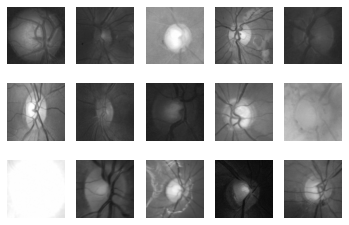

In [ ]:
# Displaying the sample of training images

k = 0
for images, labels in train_loader1:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

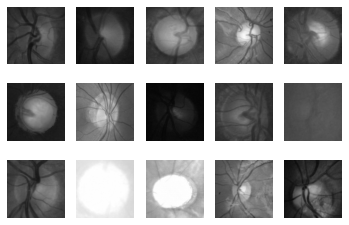

In [ ]:
# Displaying a sample of the validation data


k = 0
for images, labels in val_loader1:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

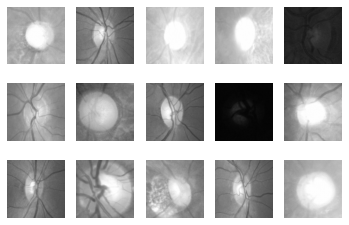

In [ ]:
# Displaying a sample of the testing data

k = 0
for images, labels in test_loader1:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

**ResNet152**

In [ ]:
model = models.resnet152(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Freezing the parameters so it doesn't train 
for param in model.parameters():
    param.requires_grad = False   

# Modifying the fc layer 
model.fc = nn.Sequential(
               nn.Linear(2048, 1024),
               nn.ReLU(inplace=True),
               nn.Linear(1024, 2)).to(device)

In [ ]:
# Run model to cuda
use_cuda = True

if use_cuda and torch.cuda.is_available():
    model.cuda() #initialize the gpu

    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


**TRAINING:**

In [ ]:
# Observe that all parameters are being optimized using SGD
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Loss function
criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_losses = []
    epoch_losses_val = []
    train_acc = []
    val_acc = []
    iters = []
    iters2 = []
    e = 0
    n = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        iters2.append(e)
        e += 1

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                if model_name == 'AlexNet':
                  alex = alexNet.to(device)
                  inputs = alex.features(inputs)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    iters.append(n)
                    n += 1

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_acc.append(epoch_acc.cpu().detach().numpy())
              epoch_losses.append(epoch_loss)
            else:
              val_acc.append(epoch_acc.cpu().detach().numpy())
              epoch_losses_val.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


        # plotting
    plt.title("Training & Validation Loss")
    plt.plot(iters2, epoch_losses, label="Train")
    plt.plot(iters2, epoch_losses_val, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters2, train_acc, label="Train")
    plt.plot(iters2, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/5
----------
train Loss: 0.4632 Acc: 0.7811
val Loss: 0.2590 Acc: 0.8885

Epoch 1/5
----------
train Loss: 0.3046 Acc: 0.8692
val Loss: 0.1699 Acc: 0.9295

Epoch 2/5
----------
train Loss: 0.2452 Acc: 0.8999
val Loss: 0.1855 Acc: 0.9432

Epoch 3/5
----------
train Loss: 0.1825 Acc: 0.9320
val Loss: 0.2058 Acc: 0.9041

Epoch 4/5
----------
train Loss: 0.1421 Acc: 0.9490
val Loss: 0.1128 Acc: 0.9609

Epoch 5/5
----------
train Loss: 0.1050 Acc: 0.9615
val Loss: 0.1870 Acc: 0.9374

Training complete in 11m 11s
Best val Acc: 0.960861


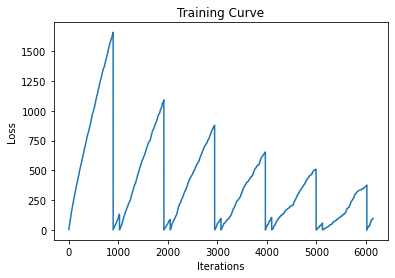

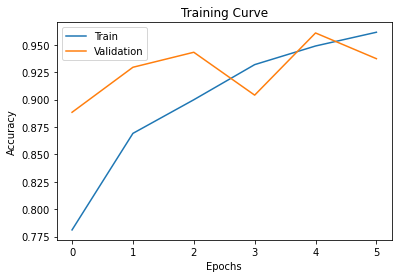

In [ ]:
# Training the model for 6 epochs
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6)

In [ ]:
# Saving the best model 
# torch.save(model_ft.state_dict(), '/content/drive/MyDrive/lmp1210_best_model_resnet152.pth')

In [ ]:
# path to the best model 
file = '/content/drive/MyDrive/lmp1210_best_model_resnet152.pth'

# Loading the parameters into the archietecture for testing on holdout data
loaded_model_res = model
loaded_model_res.load_state_dict(torch.load(file))

<All keys matched successfully>

**EVALUATION:**

**Evaluating the model on unseen colour fundus images**

In [ ]:
#  Calculating the Accuracy of the final test
def get_accuracy_res(model, test_data):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
      for data in torch.utils.data.DataLoader(test_data, batch_size=32):
          images, labels = data
          labels = labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  
  return correct/total

In [ ]:
# Accuracy on the 20% Test dataset (1024 Images)
accu = get_accuracy_res(loaded_model_res,test_loader_col)
print(f"The Accuracy for the test set is {accu}")

The Accuracy for the test set is 0.9620991253644315


In [ ]:
# Function to get the pred and label 
def get_precision_res(model, test_data):
  label = []
  pred = []
  correct = 0
  total = 0
  f1 = []
  model.eval()
  with torch.no_grad():
      for data in torch.utils.data.DataLoader(test_data, batch_size=1027):
          images, labels = data
          labels = labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs.data, 1)
          label.append(labels.cpu().detach().numpy())
          pred.append(predicted.cpu().detach().numpy())
        
  
  return pred, label

# Getting the Predictions and label for evaluation
pred, label = get_precision_res(loaded_model_res, test_loader_col)

**CONFUSION MATRIX:**

In [ ]:
# Taken from the scikit-learn documentation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Converting to dataframe to use in the confusion matrix function
df_pred = pd.DataFrame(pred)
df_label = pd.DataFrame(label)
df_label = df_label.T
df_pred = df_pred.T

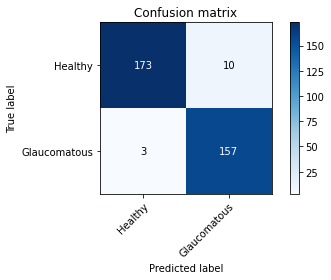

In [ ]:
# plot the confusion matrix for the test set using the ResNet152 model
plot_confusion_matrix(df_label[0],df_pred[0],
                      classes=['Healthy','Glaucomatous'])
plt.show()

**PRECISION:**

In [ ]:
#Calculating the precision score
precision_scores = []
for i in range(len(pred)):
  prec = precision_score(label[i],pred[i], average='binary', labels=np.unique(label[i]))
  precision_scores.append(prec)

final_prec = np.mean(precision_scores)
print(f"The Precision is {final_prec}")

The Precision is 0.9401197604790419


**RECALL:**

In [ ]:
#Calculating the recall score
recall_scores = []
for i in range(len(pred)):
  rec = recall_score(label[i],pred[i], average='binary', labels=np.unique(label[i]))
  recall_scores.append(rec)

final_rec = np.mean(recall_scores)
print(f"The Recall is {final_rec}")

The Recall is 0.98125


**SPECIFICITY:**

In [ ]:
# Calculating the specificity using the values from the confusion matrix
true_neg = 173
total_non_dis = 183
specificity = true_neg/(total_non_dis)
print(f"The Specificity is {specificity}")

The Specificity is 0.9453551912568307


**F1-SCORE:**

In [ ]:
# Calculating the F1 Score
f1_scores = 2 * ((final_prec*final_rec)/(final_rec+final_prec))
print(f"The F1-Score is {f1_scores}")

The F1-Score is 0.9602446483180428


**SAMPLE PREDICTIONS:**

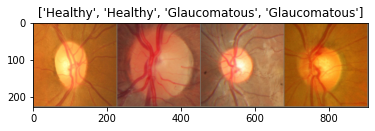

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of testing data
inputs, classes = next(iter(dataloaders_col['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def visualize_model(model, num_images=4, data_load=None):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_load['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"Label: {class_names[labels[j]]} predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

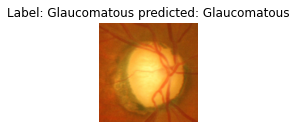

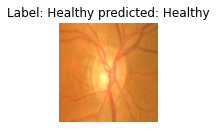

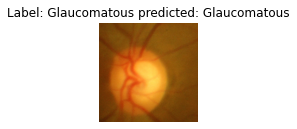

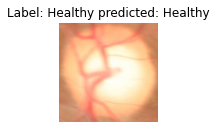

In [ ]:
visualize_model(loaded_model_res, data_load = dataloaders_col)
plt.show()

**TESTING ON A RANDOM FUNDUS IMAGE:**

In [ ]:

def process_image(image_path,coloured_img):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)

    if coloured_img == False:
      #changing the image into 3 channels
      image = np.array(pil_image)
      image = pil_image.resize((224,224))
      image = np.expand_dims(image, -1)
      image = image.repeat(3,axis=-1)
      # print(np.shape(image))
    else:
      image = pil_image
    # # Normalize
    np_image = np.array(image)/224
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

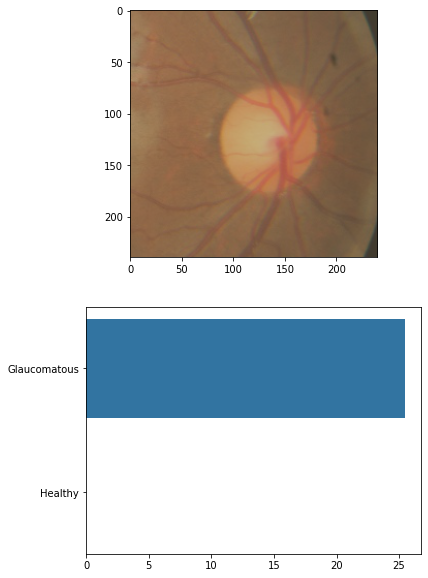

In [ ]:

# Implement the code to predict the class from an image file
def predict(image_path, model, topk=2, model_name=None, coloured_img = False):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path, coloured_img)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model(image)
    _, preds = torch.max(output, 1)
    preds = preds.cpu().detach().numpy()[0]
    
    probabilities = torch.exp(output)
    prob = probabilities.cpu().detach().numpy()[0]
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.


    # Display an image along with the confidence score
    plt.figure(figsize = (6,10))
    plot_1 = plt.subplot(2,1,1)

    image = process_image(image_path, coloured_img)


    imshow(image, plot_1)

    # Plot the probabilities for the top 5 classes as a bar graph
    plt.subplot(2,1,2)
    sb.barplot(x=prob, y=classes1, color=sb.color_palette()[0]);

    plt.show()
    
    return 

# MAKING PREDICTIONS WITH THE RESNET152 MODEL USING IMAGES FROM THE TEST SET
predict('/content/drive/MyDrive/LMP1210 PROJECT/Data/test/Glaucoma/1_282.png', loaded_model_res, coloured_img=True)   


**AlexNET**

In [ ]:
import torchvision.models
alexNet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
#Alexnet classifier Neural Network Architecture
class AlexClassifier(nn.Module):
    def __init__(self):
        super(AlexClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 20)
        self.fc3 = nn.Linear(20, 2)
        self.dropout1 = nn.Dropout(0.5) #Dropout of 50% for preventing overfitting

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(self.dropout1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Running the model on cuda
use_cuda = True

model2 = AlexClassifier()

if use_cuda and torch.cuda.is_available():
    model2.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


**TRAINING:**

In [ ]:

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses = []
    train_acc = []
    val_acc = []
    iters = []
    iters2 = []
    e = 0
    n = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        iters2.append(e)
        e += 1

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                if model_name == 'AlexNet':
                  alex = alexNet.to(device)
                  inputs = alex.features(inputs)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    iters.append(n)
                    n += 1

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                losses.append(running_loss)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_acc.append(epoch_acc.cpu().detach().numpy())
            else:
              val_acc.append(epoch_acc.cpu().detach().numpy())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


        # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters2, train_acc, label="Train")
    plt.plot(iters2, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/5
----------
train Loss: 0.2233 Acc: 0.9052
val Loss: 0.1712 Acc: 0.9159

Epoch 1/5
----------
train Loss: 0.1741 Acc: 0.9292
val Loss: 0.1577 Acc: 0.9237

Epoch 2/5
----------
train Loss: 0.1376 Acc: 0.9442
val Loss: 0.1603 Acc: 0.9198

Epoch 3/5
----------
train Loss: 0.1383 Acc: 0.9412
val Loss: 0.1604 Acc: 0.9256

Epoch 4/5
----------
train Loss: 0.1322 Acc: 0.9451
val Loss: 0.1605 Acc: 0.9256

Epoch 5/5
----------
train Loss: 0.1322 Acc: 0.9420
val Loss: 0.1600 Acc: 0.9256

Training complete in 4m 17s
Best val Acc: 0.925636


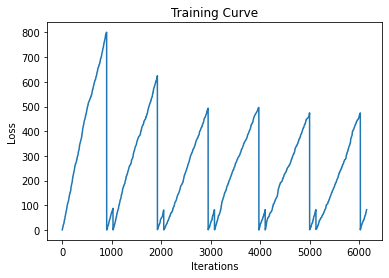

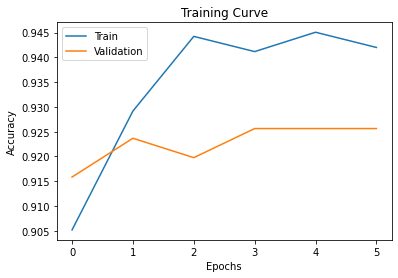

In [ ]:
# Training the alexnet model for 6 epochs
model_alex = train_model(model2, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6,model_name='AlexNet')

Epoch 0/19
----------
train Loss: 0.3866 Acc: 0.8475
val Loss: 0.3672 Acc: 0.8630

Epoch 1/19
----------
train Loss: 0.3729 Acc: 0.8511
val Loss: 0.3651 Acc: 0.8630

Epoch 2/19
----------
train Loss: 0.3615 Acc: 0.8595
val Loss: 0.3587 Acc: 0.8669

Epoch 3/19
----------
train Loss: 0.3681 Acc: 0.8544
val Loss: 0.3586 Acc: 0.8650

Epoch 4/19
----------
train Loss: 0.3666 Acc: 0.8547
val Loss: 0.3599 Acc: 0.8630

Epoch 5/19
----------
train Loss: 0.3697 Acc: 0.8542
val Loss: 0.3595 Acc: 0.8630

Epoch 6/19
----------
train Loss: 0.3678 Acc: 0.8575
val Loss: 0.3568 Acc: 0.8669

Epoch 7/19
----------
train Loss: 0.3592 Acc: 0.8586
val Loss: 0.3552 Acc: 0.8669

Epoch 8/19
----------
train Loss: 0.3600 Acc: 0.8600
val Loss: 0.3552 Acc: 0.8669

Epoch 9/19
----------
train Loss: 0.3614 Acc: 0.8622
val Loss: 0.3551 Acc: 0.8669

Epoch 10/19
----------
train Loss: 0.3518 Acc: 0.8653
val Loss: 0.3549 Acc: 0.8669

Epoch 11/19
----------
train Loss: 0.3606 Acc: 0.8617
val Loss: 0.3547 Acc: 0.8669

Ep

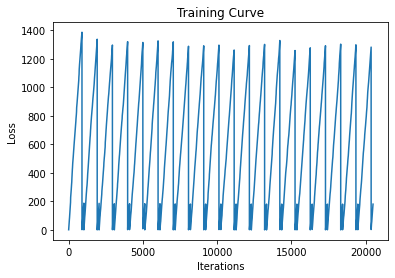

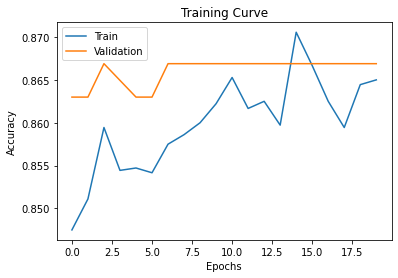

In [ ]:
# Training the alexnet model for 20 epochs
model_alex = train_model(model2, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20,model_name='AlexNet')

In [ ]:
# Saving the best model weights
# torch.save(model_alex.state_dict(), '/content/drive/MyDrive/lmp1210_best_model_alexnet.pth')

In [ ]:
# path to the best model 
file = '/content/drive/MyDrive/lmp1210_best_model_alexnet.pth'

# Loading the parameters into the archietecture for testing on holdout data
loaded_model_alex = model2
loaded_model_alex.load_state_dict(torch.load(file))


<All keys matched successfully>

**EVALUATION:**

**TEST DATA ACCURACY:**

In [ ]:
#  Calculating the Accuracy of the final test
def get_accuracy_test(model, test_data):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
      for data in torch.utils.data.DataLoader(test_data, batch_size=120):
          images, labels = data
          alex = alexNet.to(device)
          images = alexNet.features(images.to(device))
          labels = labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  
  return correct/total


In [ ]:
# Calculating the final test accuracy using alexnet 
test_acc = get_accuracy_test(loaded_model_alex, test_loader_col)
print(f"The Test Accuracy is {test_acc}")

The Test Accuracy is 0.7900874635568513


**PRECISION:**

In [ ]:
# Getting the pred and label to calculate precision and recall
def get_precision(model, test_data):
  label = []
  pred = []
  correct = 0
  total = 0
  f1 = []
  with torch.no_grad():
      for data in torch.utils.data.DataLoader(test_data, batch_size=1027):
          images, labels = data
          images = alexNet.features(images.cuda())
          labels = labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs.data, 1)
          label.append(labels.cpu().detach().numpy())
          pred.append(predicted.cpu().detach().numpy())
        
  
  return pred, label

In [ ]:
# Getting the predictions to calculate precision and recall
pred, label = get_precision(loaded_model_alex, test_loader_col)

In [ ]:
#Calculating the precision score
precision_scores = []
for i in range(len(pred)):
  prec = precision_score(label[i],pred[i], average='binary', labels=np.unique(label[i]))
  precision_scores.append(prec)

final_prec = np.mean(precision_scores)
print(f"The Precision is {final_prec}")

The Precision is 0.6981981981981982


**RECALL:**

In [ ]:
#Calculating the recall score
recall_scores = []
for i in range(len(pred)):
  rec = recall_score(label[i],pred[i], average='binary', labels=np.unique(label[i]))
  recall_scores.append(rec)

final_rec = np.mean(recall_scores)
print(f"The Recall is {final_rec}")

The Recall is 0.96875


**F1-SCORE:**

In [ ]:
# Calculating the F1 Score
f1_scores = 2 * ((final_prec*final_rec)/(final_rec+final_prec))
print(f"The F1-Score is {f1_scores}")

The F1-Score is 0.8115183246073298


**CONFUSION MATRIX:**

In [ ]:

# Taken from the scikit-learn documentation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Converting to dataframe for the confusion matrix function
df_pred = pd.DataFrame(pred)
df_label = pd.DataFrame(label)
df_label = df_label.T
df_pred = df_pred.T

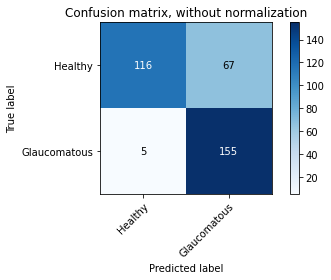

In [ ]:
# plot the confusion matrix for the test set using the ResNet152 model
plot_confusion_matrix(df_label[0],df_pred[0],
                      classes=['Healthy','Glaucomatous'])
plt.show()